<a href="https://colab.research.google.com/github/faridahelmy/NLP/blob/MS2/Milestone2_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hello Newbies

# Imports and Installations

In [ ]:
!pip install datasets
!pip install summ-eval
!pip install transformers==4.28.0

In [ ]:
import glob
import json
import re
import warnings
from typing import Union

import datasets
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from datasets import load_dataset
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from summ_eval.bleu_metric import BleuMetric
from transformers import (BartForConditionalGeneration, BartTokenizer, DataCollatorForSeq2Seq, Trainer,
                          TrainingArguments)
from tqdm.notebook import tqdm_notebook


MODELS_DIR = '/content/drive/MyDrive/newbies_nlp/models/bart_summarizer'
warnings.filterwarnings("ignore")
drive.mount('/content/drive/', force_remount=True)

# Data Loading

In [ ]:
dataset = datasets.load_dataset('cnn_dailymail', '3.0.0')
dataset_train = dataset['train'].shuffle(seed=42).select(range(10*1000))
dataset_test = dataset['test'].shuffle(seed=42).select(range(100))

  0%|          | 0/3 [00:00<?, ?it/s]

# Data Preprocessing

In [ ]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')

def preprocess_function(examples):
    inputs = examples['article']
    targets = examples['highlights']
    inputs = tokenizer(inputs, truncation=True, padding='longest')
    targets = tokenizer(targets, truncation=True, padding='longest')

    return {'input_ids': inputs.input_ids, 'attention_mask': inputs.attention_mask,
            'labels': targets.input_ids}

dataset_train = dataset_train.map(preprocess_function, batched=True)
dataset_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

# Fine-Tuning

## Initialize Base BART Model


In [ ]:
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [ ]:
torch.cuda.empty_cache()

## Training Parameters

In [ ]:
training_args = TrainingArguments(          
    num_train_epochs=1,           
    per_device_train_batch_size=1,
    fp16 = True, 
    per_device_eval_batch_size=1,   
    warmup_steps=500,               
    weight_decay=0.01,
    output_dir = MODELS_DIR,
    overwrite_output_dir = True,
    save_steps=1000
)
print(training_args.learning_rate)


5e-05


## Initializing Trainer Object

In [ ]:
trainer = Trainer(
    model=model,                       
    args=training_args,                  
    data_collator= data_collator,
    train_dataset = dataset_train          
)

## Training 

In [ ]:
trainer.train()

Step,Training Loss
500,3.705700
1000,0.630900
1500,0.580400
2000,0.571900
2500,0.547000
3000,0.550300
3500,0.516100
4000,0.564100
4500,0.533500
5000,0.511000


TrainOutput(global_step=10000, training_loss=0.6825832672119141, metrics={'train_runtime': 5023.0679, 'train_samples_per_second': 1.991, 'train_steps_per_second': 1.991, 'total_flos': 2.167104602112e+16, 'train_loss': 0.6825832672119141, 'epoch': 1.0})

## Saving Final Model

In [ ]:
trainer.save_model('/content/drive/MyDrive/newbies_nlp/trainer_versions')

# Experimentation and Evaluation

## Prediction and Evaluation Functions

In [ ]:
def compute_similarity(input_text: str, summary: str) -> float:
  input_text_words = set(input_text.split())
  summary_words = set(summary.split())
  return len(summary_words.intersection(input_text_words)) / len(summary.split())

def reformat_summary(input_text: str, summary: str)-> dict:
  return {
      'input_text': input_text,
      'summarized_text': summary,
      'similarity': compute_similarity(input_text=input_text, summary=summary),
      'input_text_sentence_count': len(input_text.split('. ')),
      'summarization_sentence_count': len(summary.split('\n')),
  }

def summarize(input_text: str, model: BartForConditionalGeneration, tokenizer: BartTokenizer, reformat: bool=False) -> str:
  # Tokenize the input text
  input_ids = tokenizer.encode(input_text, truncation=True, max_length=1024, return_tensors='pt')

  # Generate the summary
  summary_ids = model.generate(input_ids, num_beams=4, max_length=150, early_stopping=True)
  summary = tokenizer.decode(summary_ids.squeeze(), skip_special_tokens=True)
  if reformat:
    return reformat_summary(input_text=input_text, summary=summary)
  else:
    return summary

def batch_summarize(input_texts: list, model: BartForConditionalGeneration, tokenizer: BartTokenizer) -> list:
  return [
      summarize(input_text=input_text, model=model, tokenizer=tokenizer) 
      for input_text in tqdm_notebook(input_texts, desc="Genrating Summarizations: ")
  ]

def evaluate(predictions: Union[str, list], references: Union[str, list]) -> float:
  bleu = BleuMetric()
  scores_dict = bleu.evaluate_example(summary=predictions, reference=references) if isinstance(predictions, str) \
  else bleu.evaluate_batch(summaries=predictions, references=references)
  return scores_dict['bleu']

## Evaluating Final Model (trained on 10-000 samples):

In [ ]:
final_model = BartForConditionalGeneration.from_pretrained('/content/drive/MyDrive/newbies_nlp/trainer_versions')

test_articles = dataset_test['article']
ref_summs = dataset_test['highlights']
final_model_pred_summs = batch_summarize(input_texts=test_articles, model=final_model, tokenizer=tokenizer)
final_bleu_score = evaluate(predictions=final_model_pred_summs, references=ref_summs)

Genrating Summarizations:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
final_bleu_score

11.850066609586827

## Investigating which checkpoint model performed best

In [ ]:
model_dirs = glob.glob(f'{MODELS_DIR}/*')

subset_train = dataset_test.select(range(10))
subset_ref_summs = subset_train['highlights']
subset_test_articles = subset_train['article']
current_checkpoint = 0
bleu = BleuMetric()
final_scores = {}

for model_dir in tqdm_notebook(model_dirs):
  try:
    loaded_model = BartForConditionalGeneration.from_pretrained(model_dir)
  except:
    continue
  else:
    current_checkpoint = model_dir.split('/')[-1].split('-')[-1]
    print(f'current checkpoint: {current_checkpoint}')
    pred_summs = batch_summarize(input_texts=subset_test_articles, model=loaded_model, tokenizer=tokenizer)
    bleu_score = evaluate(predictions=pred_summs, references=subset_ref_summs)
    final_scores[current_checkpoint] = bleu_score

final_scores

  0%|          | 0/11 [00:00<?, ?it/s]

current checkpoint: 1000


Genrating Summarizations:   0%|          | 0/10 [00:00<?, ?it/s]

current checkpoint: 2000


Genrating Summarizations:   0%|          | 0/10 [00:00<?, ?it/s]

current checkpoint: 3000


Genrating Summarizations:   0%|          | 0/10 [00:00<?, ?it/s]

current checkpoint: 4000


Genrating Summarizations:   0%|          | 0/10 [00:00<?, ?it/s]

current checkpoint: 5000


Genrating Summarizations:   0%|          | 0/10 [00:00<?, ?it/s]

current checkpoint: 6000


Genrating Summarizations:   0%|          | 0/10 [00:00<?, ?it/s]

current checkpoint: 7000


Genrating Summarizations:   0%|          | 0/10 [00:00<?, ?it/s]

current checkpoint: 8000


Genrating Summarizations:   0%|          | 0/10 [00:00<?, ?it/s]

current checkpoint: 9000


Genrating Summarizations:   0%|          | 0/10 [00:00<?, ?it/s]

current checkpoint: 10000


Genrating Summarizations:   0%|          | 0/10 [00:00<?, ?it/s]

{'1000': 12.72343234590178,
 '2000': 9.174054724401753,
 '3000': 5.7352253413187135,
 '4000': 9.271506500260854,
 '5000': 10.690842777384768,
 '6000': 7.981334866238927,
 '7000': 10.4114537554239,
 '8000': 11.098383578310692,
 '9000': 6.105781080868287,
 '10000': 8.182316568738893}

In [ ]:
final_scores

{'1000': 12.72343234590178,
 '2000': 9.174054724401753,
 '3000': 5.7352253413187135,
 '4000': 9.271506500260854,
 '5000': 10.690842777384768,
 '6000': 7.981334866238927,
 '7000': 10.4114537554239,
 '8000': 11.098383578310692,
 '9000': 6.105781080868287,
 '10000': 8.182316568738893}

<Axes: xlabel='0', ylabel='1'>

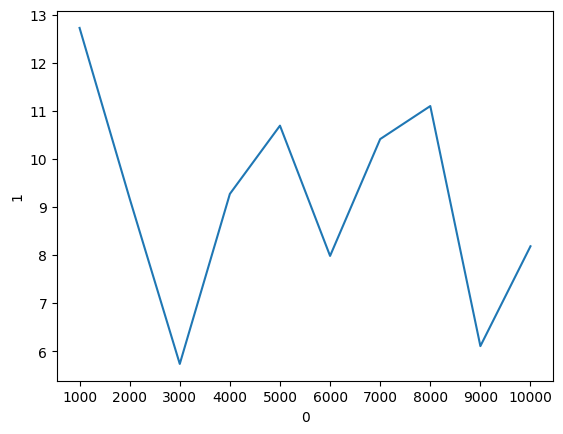

In [ ]:
df = pd.DataFrame(final_scores.items())
sns.lineplot(data=df , x=df[0], y= df[1]);

We can conclude from our graph that the model that was trained on 1000 samples performed best